In [1]:
import sys
import random
import matplotlib.pyplot as plt
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
import functools
from tqdm import tqdm
from IPython.display import display
from transformer_lens.hook_points import HookPoint
from transformer_lens import (
    utils,
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)
import circuitsvis as cv
import os
from functools import partial

import itertools
# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

if not t.backends.mps.is_available():
    if not t.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = t.device("mps")

MAIN = __name__ == "__main__"

In [2]:
from huggingface_hub import login

# Replace with your actual token
login("")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/shreyansjain/.cache/huggingface/token
Login successful


In [3]:
# model_name = "meta-llama/Llama-3.2-1B"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B"

# Load model into TransformerLens format
model = HookedTransformer.from_pretrained(model_name, device=device)

print(model)

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-15): 16 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
  

In [4]:
# text = "We think that powerful, significantly superhuman machine intelligence is more likely than not to be created this century. If current machine learning techniques were scaled up to this level, we think they would by default produce systems that are deceptive or manipulative, and that no solid plans are known for how to avoid this."
text = "Context: Alice lives in the capital city of France. Bob lives in the capital city of Thailand. Question: Which city does Bob live in? Answer:"

logits, cache = model.run_with_cache(text, remove_batch_dim=True)

model.to_string(logits[:,-1,:].argmax(dim = -1))

' Thailand'

prompt_template = f"""Answer the question based on the context below. Keep the answer short.
                        Context: {E_0} lives in the capital city of {A_0}.
                        {E_1} lives in the capital city of {A_1}.
                        Question: Which city does {qn_subject} live in?
                        Answer: {qn_subject} lives in the city of"""

In [5]:
country_list = [
    "Angola", "Austria", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Benin", "Bolivia",
    "Botswana", "Brazil", "Brunei", "Bulgaria", "Burundi", "Cambodia", "Cameroon", "Canada", "Chile", "China",
    "Colombia", "Comoros", "Croatia", "Cuba", "Cyprus", "Denmark", "Djibouti", "Ecuador", "Egypt", "Estonia",
    "Eswatini", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guyana", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran",
    "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kenya", "Kuwait", "Laos",
    "Latvia", "Lebanon", "Liberia", "Libya", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Malta",
    "Monaco", "Morocco", "Nepal", "Niger", "Norway"
]
name_list = [
    "Adam", "Alice", "Amber", "Andy", "Annie", "Ben", "Bella", "Blake", "Brent", "Brielle",
    "Caleb", "Cameron", "Carla", "Carmen", "Carter", "Chad", "Chloe", "Chris", "Clara", "Clay",
    "Colin", "Connie", "Craig", "Dana", "Dante", "David", "Dawn", "Derek", "Diana", "Dylan",
    "Eden", "Edgar", "Elena", "Elias", "Elise", "Eliza", "Ella", "Emily", "Emma", "Eric",
    "Erin", "Ethan", "Evan", "Faith", "Felix", "Fiona", "Frank", "Gabe", "Gavin", "Grace",
    "Grant", "Hanna", "Harold", "Harry", "Hazel", "Henry", "Holly", "Ian", "Iris", "Isaac",
    "Jack", "Jade", "James", "Janet", "Jason", "Jenna", "Jenny", "Jesse", "Jessica", "Joel",
    "John", "Jonah", "Joseph", "Joy", "Judy"
]

In [6]:
capital_list = [
    "Luanda", "Vienna", "Nassau", "Manama", "Dhaka", "Bridgetown", "Minsk", "Brussels", "Porto-Novo", "Sucre",
    "Gaborone", "Brasília", "Bandar", "Sofia", "Gitega", "Phnom", "Yaoundé", "Ottawa", "Santiago", "Beijing",
    "Bogotá", "Moroni", "Zagreb", "Havana", "Nicosia", "Copenhagen", "Djibouti", "Quito", "Cairo", "Tallinn",
    "Mbabane", "Suva", "Helsinki", "Paris", "Libreville", "Banjul", "Tbilisi", "Berlin", "Accra", "Athens",
    "StGeorge's", "Guatemala", "Conakry", "Georgetown", "Tegucigalpa", "Budapest", "Reykjavik", "Delhi", "Jakarta", "Tehran",
    "Baghdad", "Dublin", "Jerusalem", "Rome", "Kingston", "Tokyo", "Amman", "Nairobi", "Kuwait", "Vientiane",
    "Riga", "Beirut", "Monrovia", "Tripoli", "Vilnius", "Luxembourg", "Antananarivo", "Lilongwe", "Kuala", "Valletta",
    "Monaco", "Rabat", "Kathmandu", "Niamey", "Oslo"
]

single_token_capitals = [capital for capital in capital_list if len(capital.split())== 1]
len(capital_list), len(single_token_capitals)

(75, 75)

In [7]:
valid_indices = [capital_list.index(capital) for capital in single_token_capitals]
valid_countries = list(np.array(country_list)[valid_indices])
valid_names = name_list[:len(valid_countries)]

In [8]:
len(valid_countries), len(valid_names)

(75, 75)

In [9]:
country_perms = list(itertools.permutations(valid_countries, 2))
name_perms = list(itertools.permutations(valid_names, 2))

random.shuffle(country_perms)
random.shuffle(name_perms)

In [163]:
prompt_list = []
factual_answers = []
for country, name in zip(country_perms, name_perms):
# for country, name in zip(valid_countries, valid_names):
    
    # prompt_1 = f"""Answer the question based on the context below. Keep the answer short.
    #                     Context: {name} lives in the capital city of {country}.
    #                     Question: Which city does {name} live in?
    #                     Answer: {name} lives in the city of"""

    prompt_1 = f"""Answer the question based on the context below. Keep the answer short.
                        Context: {name[0]} lives in the capital city of {country[0]}.
                        {name[1]} lives in the capital city of {country[1]}.
                        Question: Which city does {name[0]} live in?
                        Answer: {name[0]} lives in the city of"""

    # prompt_2 = f"""Answer the question based on the context below. Keep the answer short.
    #                     Context: {name[0]} lives in the capital city of {country[0]}.
    #                     {name[1]} lives in the capital city of {country[1]}.
    #                     Question: Which city does {name[1]} live in?
    #                     Answer: {name[1]} lives in the city of"""

    # prompt_list.extend([prompt_1, prompt_2])
    prompt_list.append(prompt_1)
    factual_answers.extend([single_token_capitals[valid_countries.index(country[0])]])
    # factual_answers.append(single_token_capitals[valid_countries.index(country)])

In [165]:
prompt_list[1], factual_answers[1]

('Answer the question based on the context below. Keep the answer short.\n                        Context: Colin lives in the capital city of Brunei.\n                        Eliza lives in the capital city of Eswatini.\n                        Question: Which city does Colin live in?\n                        Answer: Colin lives in the city of',
 'Bandar')

In [12]:
logits, cache = model.run_with_cache(prompt_list[1], remove_batch_dim=True)
model.to_string(logits[:,-1,:].argmax(dim = -1))

' Br'

# Binding ID Replication

In [13]:
def get_index_dict(prompt_list, valid_perms, attribute = True):
    """Get the indices of respective entity (name or country) in the prompt.
    This will help to determine the indices of activations to be patched

    Args:
        prompt_list (List): List of prompts
        valid_entries (List): List of valid entries (valid names or country)

    Returns:
        Dict: Dictionary of each entity and list of indices in the prompt
    """
    index_dict = {}
    for n,prompt in enumerate(prompt_list):
        tokens = model.to_str_tokens(prompt_list[n])
        if str(n) not in index_dict.keys():
            index_dict[str(n)] = {}
        for m, token in enumerate(tokens):
            for j,perm in enumerate(valid_perms[n]):
                if perm.strip().lower() in token.strip().lower() and token.strip().lower() != '':
                    if attribute:
                        if f"A_{j}" not in index_dict[str(n)].keys():
                            index_dict[str(n)][f"A_{j}"] = [m]
                    else:
                        if f"E_{j}" not in index_dict[str(n)].keys():
                            index_dict[str(n)][f"E_{j}"] = [m]
    return index_dict

In [84]:
split_index = 50
train_name_index_dict = get_index_dict(prompt_list[:split_index], name_perms[:split_index])
train_country_index_dict = get_index_dict(prompt_list[:split_index], country_perms[:split_index], attribute=False)

test_name_index_dict = get_index_dict(prompt_list[split_index: split_index*2], name_perms[split_index:split_index*2])
test_country_index_dict = get_index_dict(prompt_list[split_index:split_index*2], country_perms[split_index:split_index*2],attribute=False)

In [167]:
train_factual_answers = factual_answers[:split_index]
test_factual_answers = factual_answers[split_index:split_index*2]

In [85]:
train_prompt_list = prompt_list[:split_index]
test_prompt_list = prompt_list[split_index:split_index*2]

In [87]:
def get_activation_dict(prompt_list, index_dict, n_layers):
    """Get the average activations for the entity across all the layers

    Args:
        prompt_list (List): List of prompts
        index_dict (Dict): Dictionary containing index of the entities
        n_layers (int): No of layers

    Returns:
        Dict: Dictionary of mean activation of every entity across all the layers
    """
    activation_dict = {}
    for key in index_dict.keys():
        if len(index_dict[key].keys()) > 1:
            print(key)
            prompt = prompt_list[int(key)]
            logits, cache = model.run_with_cache(prompt, remove_batch_dim=True)
            activation_dict[key] = {}
            for child_key in index_dict[key]:
                act_tensor = t.zeros((2048,n_layers))
                for layer in range(n_layers):
                    mean_activation = cache["resid_pre",layer][index_dict[key][child_key]].mean(dim = 0)
                    act_tensor[:,layer] = mean_activation
            
                activation_dict[key][child_key] = act_tensor
    
    return activation_dict

In [88]:
train_named_activation_dict = get_activation_dict(train_prompt_list, train_name_index_dict, model.cfg.n_layers)
test_named_activation_dict = get_activation_dict(test_prompt_list, test_name_index_dict, model.cfg.n_layers)

0
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
29
30
31
32
33
35
36
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [89]:
train_country_activation_dict = get_activation_dict(train_prompt_list, train_country_index_dict, model.cfg.n_layers)
test_country_activation_dict = get_activation_dict(test_prompt_list, test_country_index_dict, model.cfg.n_layers)

0
3
6
8
9
10
11
12
13
14
15
18
19
20
21
22
23
28
31
32
33
34
35
40
41
43
44
45
46
47
48
49
4
6
7
8
9
10
12
14
15
17
18
22
24
25
26
27
28
30
31
35
36
37
38
39
41
42
44
45
46
47
48


def calculate_delta_tensor(activation_dict, entity):
    
    delta_tensor = 0
    other_keys = [key for key in activation_dict.keys() if key != entity]
    for key in other_keys:
        delta_tensor += activation_dict[entity] - activation_dict[key]
    
    return (delta_tensor/len(other_keys)).to(device)

In [107]:
logits, cache = model.run_with_cache(test_prompt_list[0], remove_batch_dim=True)
cache["resid_pre",0][31]

tensor([ 0.0136,  0.0281,  0.0062,  ..., -0.0396,  0.0176,  0.0391],
       device='mps:0')

In [108]:
test_name_index_dict['0'], test_named_activation_dict['0']['A_1'][:,0]

({'A_0': [18], 'A_1': [31]},
 tensor([ 0.0136,  0.0281,  0.0062,  ..., -0.0396,  0.0176,  0.0391]))

In [109]:
def calculate_delta_tensor(activation_dict):
    
    delta_tensor = 0
    for key in activation_dict.keys():
        activation_list = list(activation_dict[key].values())
        delta_tensor += activation_list[1] - activation_list[0]
        
    return (delta_tensor/len(activation_dict.keys())).to(device)

In [110]:
train_name_delta_tensor = calculate_delta_tensor(train_named_activation_dict)
train_country_delta_tensor = calculate_delta_tensor(train_country_activation_dict)

In [111]:
train_name_delta_tensor.shape, train_country_delta_tensor.shape

(torch.Size([2048, 16]), torch.Size([2048, 16]))

# Replicating Mean Intervention on all resid_pre activations for all layers

In [113]:
def patching_experiment(model,prompt,delta_tensor, index_dict, hook_layers):
    
    index_list = [value[0] for value in index_dict.values()]
    
    def patch_residual_component(name):
        def hook(module, corrupted_residual_component: Float[t.Tensor, "batch pos d_model"], output
            ):
            (input,) = corrupted_residual_component
            # print(module.name.split('.')[1])
            # print(input.shape)
            input[:, index_list[0], :] += delta_tensor[:, int(module.name.split('.')[1])].repeat(input[:, index_list[0], :].shape[0],1)
            input[:, index_list[1], :] -= delta_tensor[:, int(module.name.split('.')[1])].repeat(input[:, index_list[1], :].shape[0],1)
            return input
        return hook
    
    # print("Output before patching")
    logits = model(prompt)
    before_output_token = model.to_string(logits[:,-1,:].argmax(dim = -1))
    # print(before_output_token)
    
    handles = []
    for name, module in model.named_modules():
        if name in hook_layers:
            handles.append(module.register_forward_hook(patch_residual_component(name)))
    
    # print("Output After patching")
    print(f"No of layers on which activation was patched starting from first: {len(hook_layers)}")
    logits = model(prompt)
    after_output_token = model.to_string(logits[:,-1,:].argmax(dim = -1))
    # print(after_output_token)
    
    for handle in handles:
        handle.remove()

    return {
        "before_patching" :before_output_token,
        "n_layers_patched": len(hook_layers),
        "after_patching": after_output_token
        }

In [115]:
resid_pre_layers = [name for name, module in model.named_modules() if "resid_pre" in name]

In [116]:
patching_experiment(model,train_prompt_list[0], train_name_delta_tensor, train_name_index_dict['0'], resid_pre_layers[:16])

No of layers on which activation was patched starting from first: 16


{'before_patching': ' Liberia',
 'n_layers_patched': 16,
 'after_patching': ' Liberia'}

In [117]:
patching_experiment(model,train_prompt_list[2], train_name_delta_tensor, train_name_index_dict['2'], resid_pre_layers[:16])

No of layers on which activation was patched starting from first: 16


{'before_patching': ' Barb', 'n_layers_patched': 16, 'after_patching': ' Barb'}

In [118]:
patching_experiment(model,train_prompt_list[0], train_country_delta_tensor, train_country_index_dict['0'], resid_pre_layers[:15])

No of layers on which activation was patched starting from first: 15


{'before_patching': ' Liberia', 'n_layers_patched': 15, 'after_patching': ' M'}

In [119]:
train_named_patching_result = {}
for n, index in enumerate(train_named_activation_dict):
    print("prompt_no", index)
    # print(prompt_list[n])
    train_named_patching_result[index] = []
    for i in range(len(resid_pre_layers)):
        train_named_patching_result[index].append(patching_experiment(model,train_prompt_list[int(index)], train_name_delta_tensor, train_name_index_dict[index], resid_pre_layers[:i]))

prompt_no 0
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation

In [126]:
test_named_patching_result = {}
for n, index in enumerate(test_named_activation_dict):
    print("prompt_no", index)
    # print(prompt_list[n])
    test_named_patching_result[index] = []
    for i in range(len(resid_pre_layers)):
        test_named_patching_result[index].append(patching_experiment(model,test_prompt_list[int(index)], train_name_delta_tensor, test_name_index_dict[index], resid_pre_layers[:i]))

prompt_no 0
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation

In [124]:
train_country_patching_result = {}
for n, index in enumerate(train_country_activation_dict):
    print("prompt_no", index)
    # print(prompt_list[n])
    train_country_patching_result[index] = []
    for i in range(len(resid_pre_layers)):
        train_country_patching_result[index].append(patching_experiment(model,train_prompt_list[int(index)], train_country_delta_tensor, train_country_index_dict[index], resid_pre_layers[:i]))

prompt_no 0
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation

In [127]:
test_country_patching_result = {}
for n, index in enumerate(test_country_activation_dict):
    print("prompt_no", index)
    # print(prompt_list[n])
    test_country_patching_result[index] = []
    for i in range(len(resid_pre_layers)):
        test_country_patching_result[index].append(patching_experiment(model,test_prompt_list[int(index)], train_country_delta_tensor, test_country_index_dict[index], resid_pre_layers[:i]))

prompt_no 4
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation

In [66]:
import json

with open('test_named_patching_result.json', 'w') as f:
    json.dump(test_named_patching_result, f)

with open('test_country_patching_result.json', 'w') as f:
    json.dump(test_country_patching_result, f)

In [47]:
prompt_list[44]

'Answer the question based on the context below. Keep the answer short.\n                        Context: Reid lives in the capital city of Uzbekistan.\n                        Question: Which city does Reid live in?\n                        Answer: Reid lives in the city of'

with open('named_patching_result_llama1b_Inst.json') as f:
    named_patching_result = json.load(f)

with open('country_patching_result_llama1b_Inst.json') as f:
    country_patching_result = json.load(f)

In [130]:
train_named_patching_result_v2 = {}
for i in range(16):
    train_named_patching_result_v2[str(i)] = []
    for key in train_named_patching_result:
        train_named_patching_result_v2[str(i)].append(train_named_patching_result[key][i])

In [131]:
test_named_patching_result_v2 = {}
for i in range(16):
    test_named_patching_result_v2[str(i)] = []
    for key in test_named_patching_result:
        test_named_patching_result_v2[str(i)].append(test_named_patching_result[key][i])

In [132]:
train_country_patching_result_v2 = {}
for i in range(16):
    train_country_patching_result_v2[str(i)] = []
    for key in train_country_patching_result:
        train_country_patching_result_v2[str(i)].append(train_country_patching_result[key][i])

In [133]:
test_country_patching_result_v2 = {}
for i in range(16):
    test_country_patching_result_v2[str(i)] = []
    for key in test_country_patching_result:
        test_country_patching_result_v2[str(i)].append(test_country_patching_result[key][i])

In [175]:
train_factual_answers[4], train_prompt_list[4]

('Santiago',
 'Answer the question based on the context below. Keep the answer short.\n                        Context: Connie lives in the capital city of Chile.\n                        Isaac lives in the capital city of Gambia.\n                        Question: Which city does Connie live in?\n                        Answer: Connie lives in the city of')

In [174]:
train_named_patching_result['4'][0]

{'before_patching': ' Santiago',
 'n_layers_patched': 0,
 'after_patching': ' Santiago'}

In [178]:
def factual_accuracy(result_dict, factual_answers):
    accuracy_list = []
    for key in result_dict:
        model_output = result_dict[key][0]['before_patching'].strip().lower()
        accuracy_list.append(1 if model_output in factual_answers[int(key)].strip().lower() else 0)
    return sum(accuracy_list)/len(result_dict.keys())

In [187]:
def layer_wise_accuracy(result_dict):
    accuracy_list = []
    for key in result_dict:
        results = result_dict[key]
        accuracy = sum([1 if result['before_patching'] == result['after_patching'] else 0 for result in result_dict[key]])/len(result_dict[key])
        accuracy_list.append(np.round(accuracy,2))
    return accuracy_list

In [186]:
factual_accuracy(train_named_patching_result, train_factual_answers)

0.6888888888888889

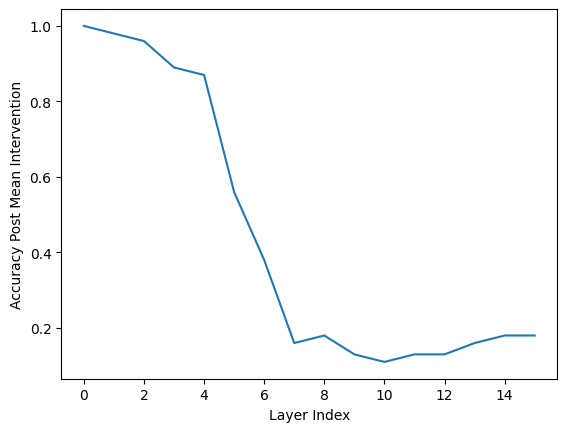

In [193]:
plt.plot(layer_wise_accuracy(train_named_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()

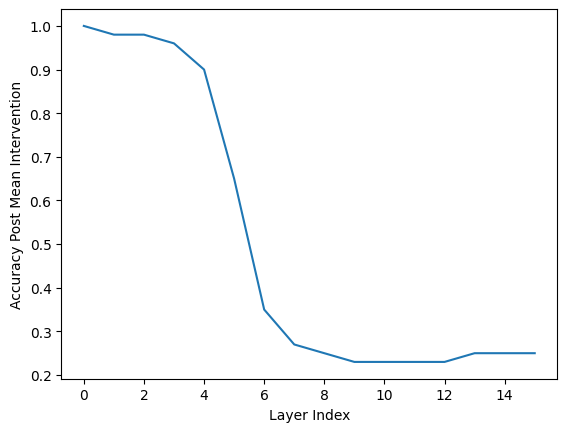

In [189]:
plt.plot(layer_wise_accuracy(test_named_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()

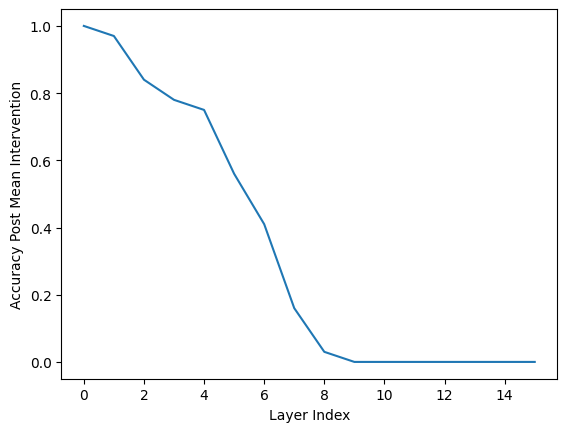

In [192]:
plt.plot(layer_wise_accuracy(train_country_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()

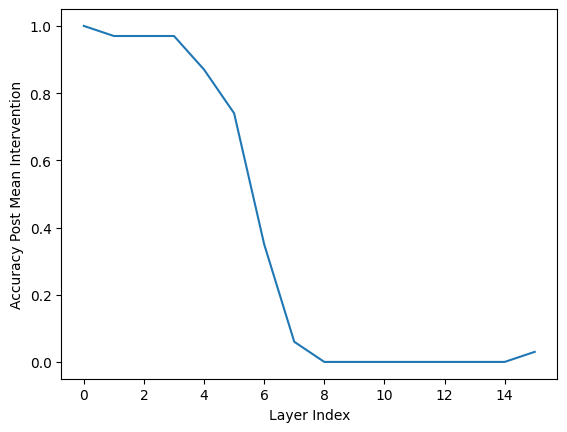

In [191]:
plt.plot(layer_wise_accuracy(test_country_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()